<a href="https://colab.research.google.com/github/hws2002/Time_Series_Forecasting_in_Python/blob/main/Chaper7/Chapter7_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/jj.csv")
df

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


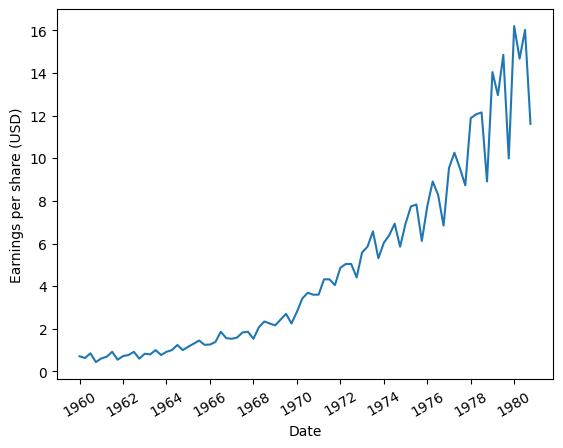

In [8]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()


plt.plot(df['date'], df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(
    np.arange(0, 81, 8),
    [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980]
)
plt.xticks(rotation = 30)
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

ADF_test = adfuller(df.data)
ADF_test

(2.7420165734574744,
 1.0,
 11,
 72,
 {'1%': -3.524624466842421,
  '5%': -2.9026070739026064,
  '10%': -2.5886785262345677},
 82.63760283301104)

p-value가 0.05보다 높으므로, 수열이 비정상적임을 알 수 있다.  
차분을 진행해보자

In [10]:
eps_diff = np.diff(df['data'], n = 1)

In [11]:
ADF_test = adfuller(eps_diff)
ADF_test

(-0.40740976363804615,
 0.9088542416911305,
 10,
 72,
 {'1%': -3.524624466842421,
  '5%': -2.9026070739026064,
  '10%': -2.5886785262345677},
 89.21317134038213)

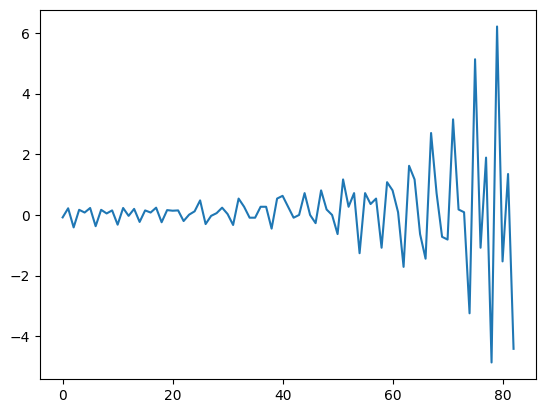

In [12]:
plt.plot(eps_diff)
plt.show()

아직도 p-value가 0.05보다 크므로, 수열이 비정상적이다.  
다시한 번 차분을 진행해보자

(-3.585162874793155, 0.006051099869603682, 9, 72, {'1%': -3.524624466842421, '5%': -2.9026070739026064, '10%': -2.5886785262345677}, 87.33900055833058)


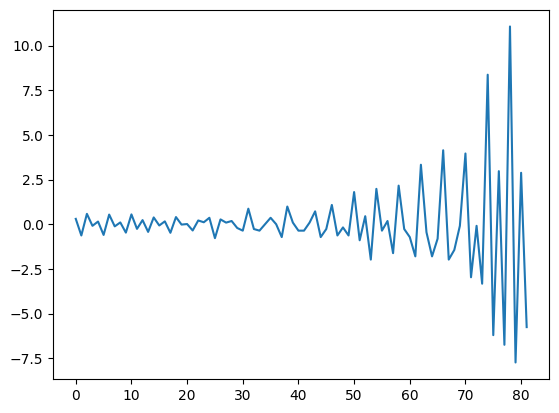

In [14]:
eps_diff2= np.diff(eps_diff, n = 1)

ADF_test = adfuller(eps_diff2)
print(ADF_test)

plt.plot(eps_diff2)

이제 p-value가 0.05보다 작으므로 귀무가설을 기각하고 시계열이 정상적이라는 결론을 내릴 수 있음.  

데이터를 정상적으로 만들기 위해 두번 차분했으므로 적분 차수는 2이고, d = 2이다.

# 훈련 테스트 집합 분리
테스트 집합에는 지난 1년간의 데이터를 포함해보자  
즉, 1980년의 분기별 EPS를 예측해볼것이다.

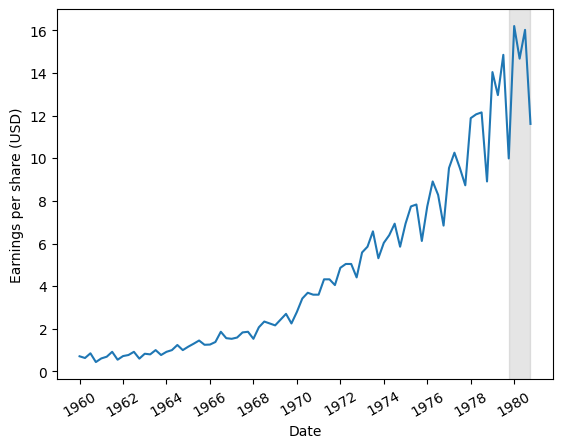

In [21]:
fig, ax = plt.subplots()


plt.plot(df['date'], df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(
    np.arange(0, 81, 8),
    [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980]
)

ax.axvspan(83-4, 83, color = "#808080", alpha = 0.2)
plt.xticks(rotation = 30)
plt.show()

In [16]:
print(eps_diff2.shape)

(82,)


In [72]:
train = df.data[:-4]
test = df.data[-4:]

# 모델 피팅
optimize_ARIMA함수를 만들어 모델을 피팅해보자

In [74]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog : Union[pd.Series, list], order_list : list, d : int) -> pd.DataFrame:
  results = []

  for order in tqdm_notebook(order_list):
    p,q = order[0], order[1]
    try :
      model = SARIMAX(endog, order = (p,d,q), simple_differencing = False).fit(disp = False)
    except :
      continue
    aic = model.aic
    results.append([order,aic])

  results_df = pd.DataFrame(results)
  results_df.columns = ['(p,q)', 'AIC']

  results_df = results_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)
  return results_df


In [75]:
from itertools import product

ps = range(0,4,1)
qs = range(0,4,1)
d = 2
order_list = list(product(ps,qs))

result_df = optimize_ARIMA(train, order_list, d)
result_df

<ipython-input-74-fafca942a4a4>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conve

,"(p,q)",AIC
0,"(3, 3)",115.266637
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430625
4,"(0, 3)",194.654716
5,"(0, 2)",209.274868
6,"(2, 3)",220.666965
7,"(1, 3)",228.267730
8,"(1, 2)",228.935782
9,"(2, 2)",229.974691


반환된 DataFrame은 p와 q모두에 대해 3이 가장 낮은 AIC라는 것을 보여준다.  
따라서 이상황에서는 ARIMA(3,3)모델이 가장 적합한 것으로보인다.  
이제 잔차를 조사하여 모델의 유효성을 평가해보자.  


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


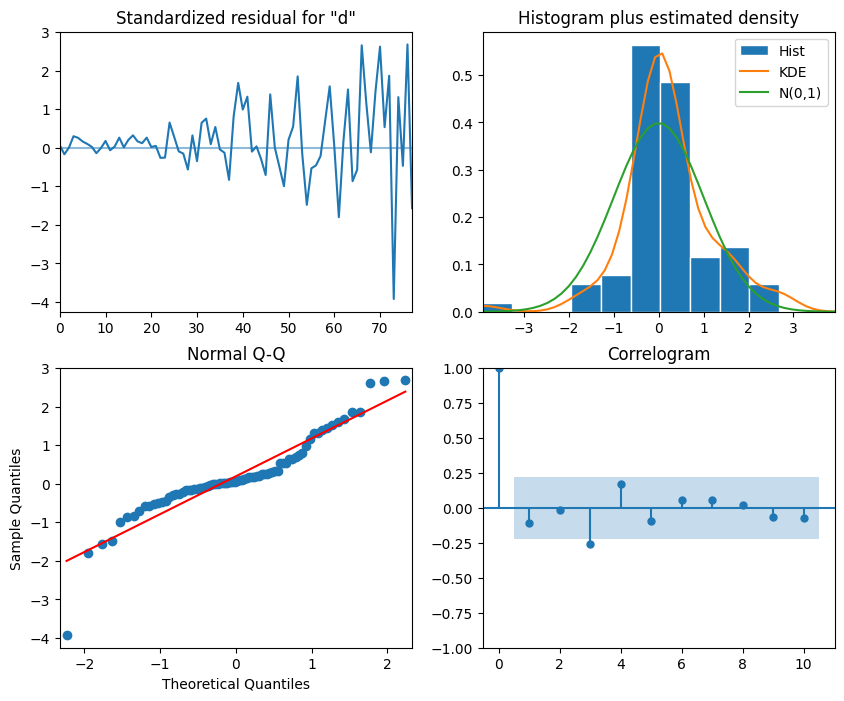

In [76]:
model = SARIMAX(train, order= (3,2,3), simple_differencing = False)
model_fit = model.fit(disp = False)

model_fit.plot_diagnostics(figsize = (10,8));

왼쪽 상단 도식은 시간 경과에 따른 잔차를 보여준다. 잔차에 추세는 없지만 분산이 일정하지 않은 것으로 보이며, 이는 백색소음과 차이가 있다.    
오른쪽 상단은 잔차의 분포인데, 정규분포에 상당히 가깝다는 것을 알 수 있다.  
Q-Q도식에서도 끝부분에 약간의 편차가 있는 것을 제외하고는 정규분포를 따른다고 볼 수 있다.  
마지막으로, 상관관계도를 보면 지연 3에서 계수가 유의한 것으로 보인다. 하지만 그 앞에 유의한 자기상관계수가 없기 때문에 이는 우연에 의한 것으로 추정할 수 있다.
따라서 상관관계도는 백색소음과 마찬가지로 지연 0 이후에는 유의한 계수가 나타나지 않는다고 말할 수 있다.  

정량적 관점에서 잔차를 평가해보자

In [77]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1,11,1))
tr

,lb_stat,lb_pvalue
1,1.652020,0.198684
2,1.654544,0.437241
3,7.276173,0.063597
4,9.231226,0.055573
5,9.853425,0.079497
6,10.097125,0.120621
7,10.346926,0.169751
8,10.379005,0.239426
9,10.721222,0.295303
10,11.159917,0.345196


처음 10개의 지연에 대해 융 박스 테스트를 한 결과 모든 지연에 대해 p-value가 0.05보다 높음을 확인할 수 있다.  

# 예측

In [78]:
test = pd.DataFrame(test)

In [79]:
len(eps_diff2)

82

In [80]:
test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,data,naive_seasonal
80,16.20,14.04
81,14.67,12.96
82,16.02,14.85
83,11.61,9.99


In [84]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean
test['ARIMA_pred'] = ARIMA_pred
test

,data,naive_seasonal,ARIMA_pred
80,16.20,14.04,15.858693
81,14.67,12.96,14.381508
82,16.02,14.85,16.365509
83,11.61,9.99,11.680906


In [103]:
np.arange(70,83,5)

array([70, 75, 80])

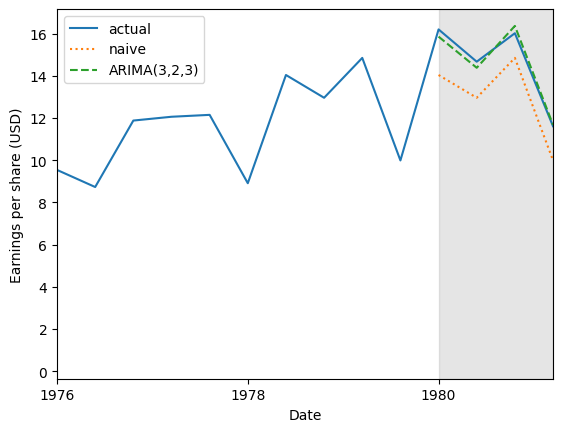

In [104]:
fig, ax = plt.subplots()
plt.plot(df.data, label = 'actual')
# plt.plot(test['data'], label = 'Actual')
plt.plot(test['naive_seasonal'], linestyle = ':', label = 'naive')
plt.plot(test['ARIMA_pred'], linestyle = '--',label = 'ARIMA(3,2,3)')
plt.xlim(70, 83)
plt.xticks(
    np.arange(70,83,5),
    [1976, 1978, 1980]
)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color = '#808080', alpha = 0.2)
plt.legend()
plt.show()

도식에서 ARIMA(3,2,3)모델이 매우 작은 오차로 분기별 EPS를 예측했음을 볼 수 있다.  
평균절대백분율오차를 측정하여 이 오차를 정량화하고 각 예측 방법에 대한 지표를 막대형 차트에 표시해보자

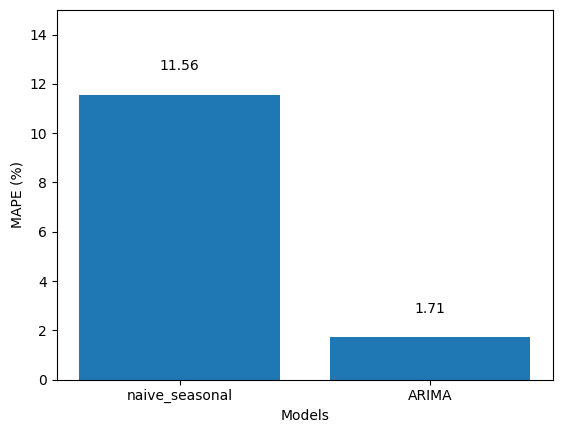

In [114]:
# from sklearn.metrics import mean_absolute_error

def mape(y_true, y_pred):
  return np.mean(np.abs( (y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

model_nm = ['naive_seasonal', 'ARIMA']
maes = [mape_naive_seasonal, mape_ARIMA]


fig, ax = plt.subplots()
plt.bar(model_nm, maes)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0,15)

for index, height in enumerate(maes):
  plt.text(x = index, y = height+1, s = str(round(height,2)), ha = 'center')

plt.show()

단순한 계절 예측의 MAPE는 11.56%인 반면, ARIMA(3,3) 모델의 MAPE는 1.73%로 벤치마크값의 약 5분의 1 수준임을 알 수 있다.  
즉 예측값이 실젯값에서 평균적으로 1.73% 정도 차이를 보인다는 것을 뜻한다.  
ARIMA(3,2,3) 모델이 단순한 계절적 방법보다 더 나은 모델임이 분명하다.